In [162]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Import data
- Remove features and target column.

In [163]:
df = pd.read_csv('/app/data/sales_property_and_geo.csv')

df_original = df.copy()

df.drop(["Category","URL","plan","address","features","address_block","converted_address"], axis=1, inplace=True)

df.head()

,price,area,balcony_area,level,no_floors,year,rooms,living_room,dining_room,kitchen,storage,latitude,longitude
0,"11,900,000.0",41.3,2.4,2.0,4.0,1979,2,False,True,True,0,35.8,139.8
1,"13,800,000.0",16.4,2.7,5.0,9.0,1991,1,False,False,True,0,35.7,139.8
2,"29,800,000.0",43.1,4.6,9.0,12.0,1975,2,False,True,True,0,35.7,139.8
3,"34,900,000.0",65.0,7.5,4.0,14.0,1984,3,True,True,True,0,35.7,139.8
4,"41,800,000.0",54.1,8.9,7.0,10.0,2011,2,True,True,True,0,35.7,139.8


In [164]:
# Filter the DataFrame for areas greater than 400 square meters
df[df['no_floors'] > 100]


,price,area,balcony_area,level,no_floors,year,rooms,living_room,dining_room,kitchen,storage,latitude,longitude


## Check columns for NaN

In [165]:
df.isna().sum().to_frame(name='NaNs').T

,price,area,balcony_area,level,no_floors,year,rooms,living_room,dining_room,kitchen,storage,latitude,longitude
NaNs,0,0,1383,0,1,0,0,0,0,0,0,0,0


## NaNs
- Balcony area contains NaN if there is no balcony.
- Remove any other NaNs.

In [166]:
df['balcony_area'] = df['balcony_area'].fillna(0)

df = df.dropna()

## Train and test split

In [167]:
X = df.drop(["price"], axis=1)
y = df["price"]

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pd.set_option('display.float_format', '{:,.1f}'.format)
X_train.describe()

,area,balcony_area,level,no_floors,year,rooms,storage,latitude,longitude
count,"16,776.0","16,776.0","16,776.0","16,776.0","16,776.0","16,776.0","16,776.0","16,776.0","16,776.0"
mean,61.9,8.6,5.9,11.2,"1,992.7",2.1,0.1,35.7,139.7
std,21.0,6.8,6.2,9.1,15.6,0.8,0.3,0.1,0.1
min,3.2,0.0,1.0,1.0,"1,927.0",1.0,0.0,35.5,139.6
25%,48.9,4.7,2.0,6.0,"1,979.0",1.0,0.0,35.6,139.7
50%,60.5,7.3,4.0,9.0,"1,992.0",2.0,0.0,35.7,139.7
75%,71.8,11.0,7.0,13.0,"2,005.0",3.0,0.0,35.7,139.8
max,266.8,108.0,60.0,60.0,"2,025.0",6.0,1.0,35.8,139.9


In [168]:
y_train.describe()

count          16,776.0
mean       71,581,095.0
std        76,871,184.3
min         5,800,000.0
25%        35,900,000.0
50%        49,800,000.0
75%        78,800,000.0
max     1,350,000,000.0
Name: price, dtype: float64

In [169]:
sns.set_theme(style="whitegrid")

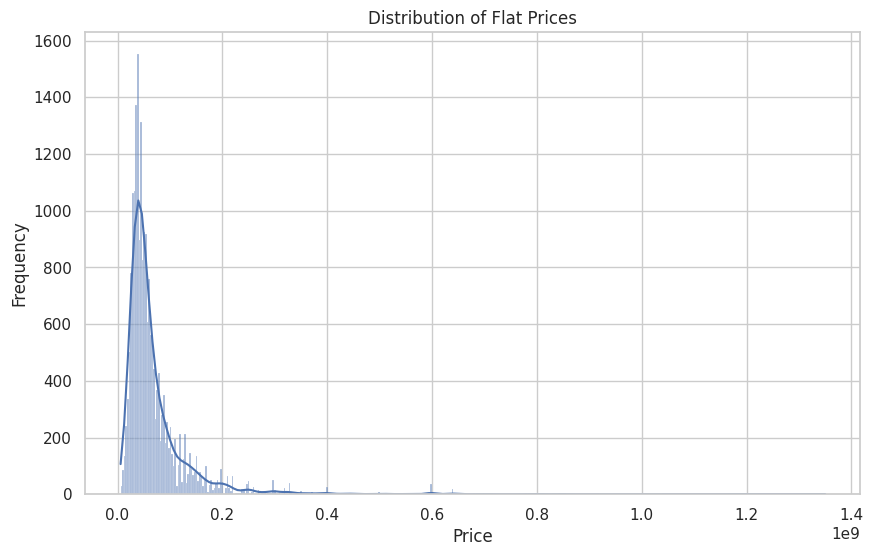

In [170]:
# 1. Histogram for price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Flat Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

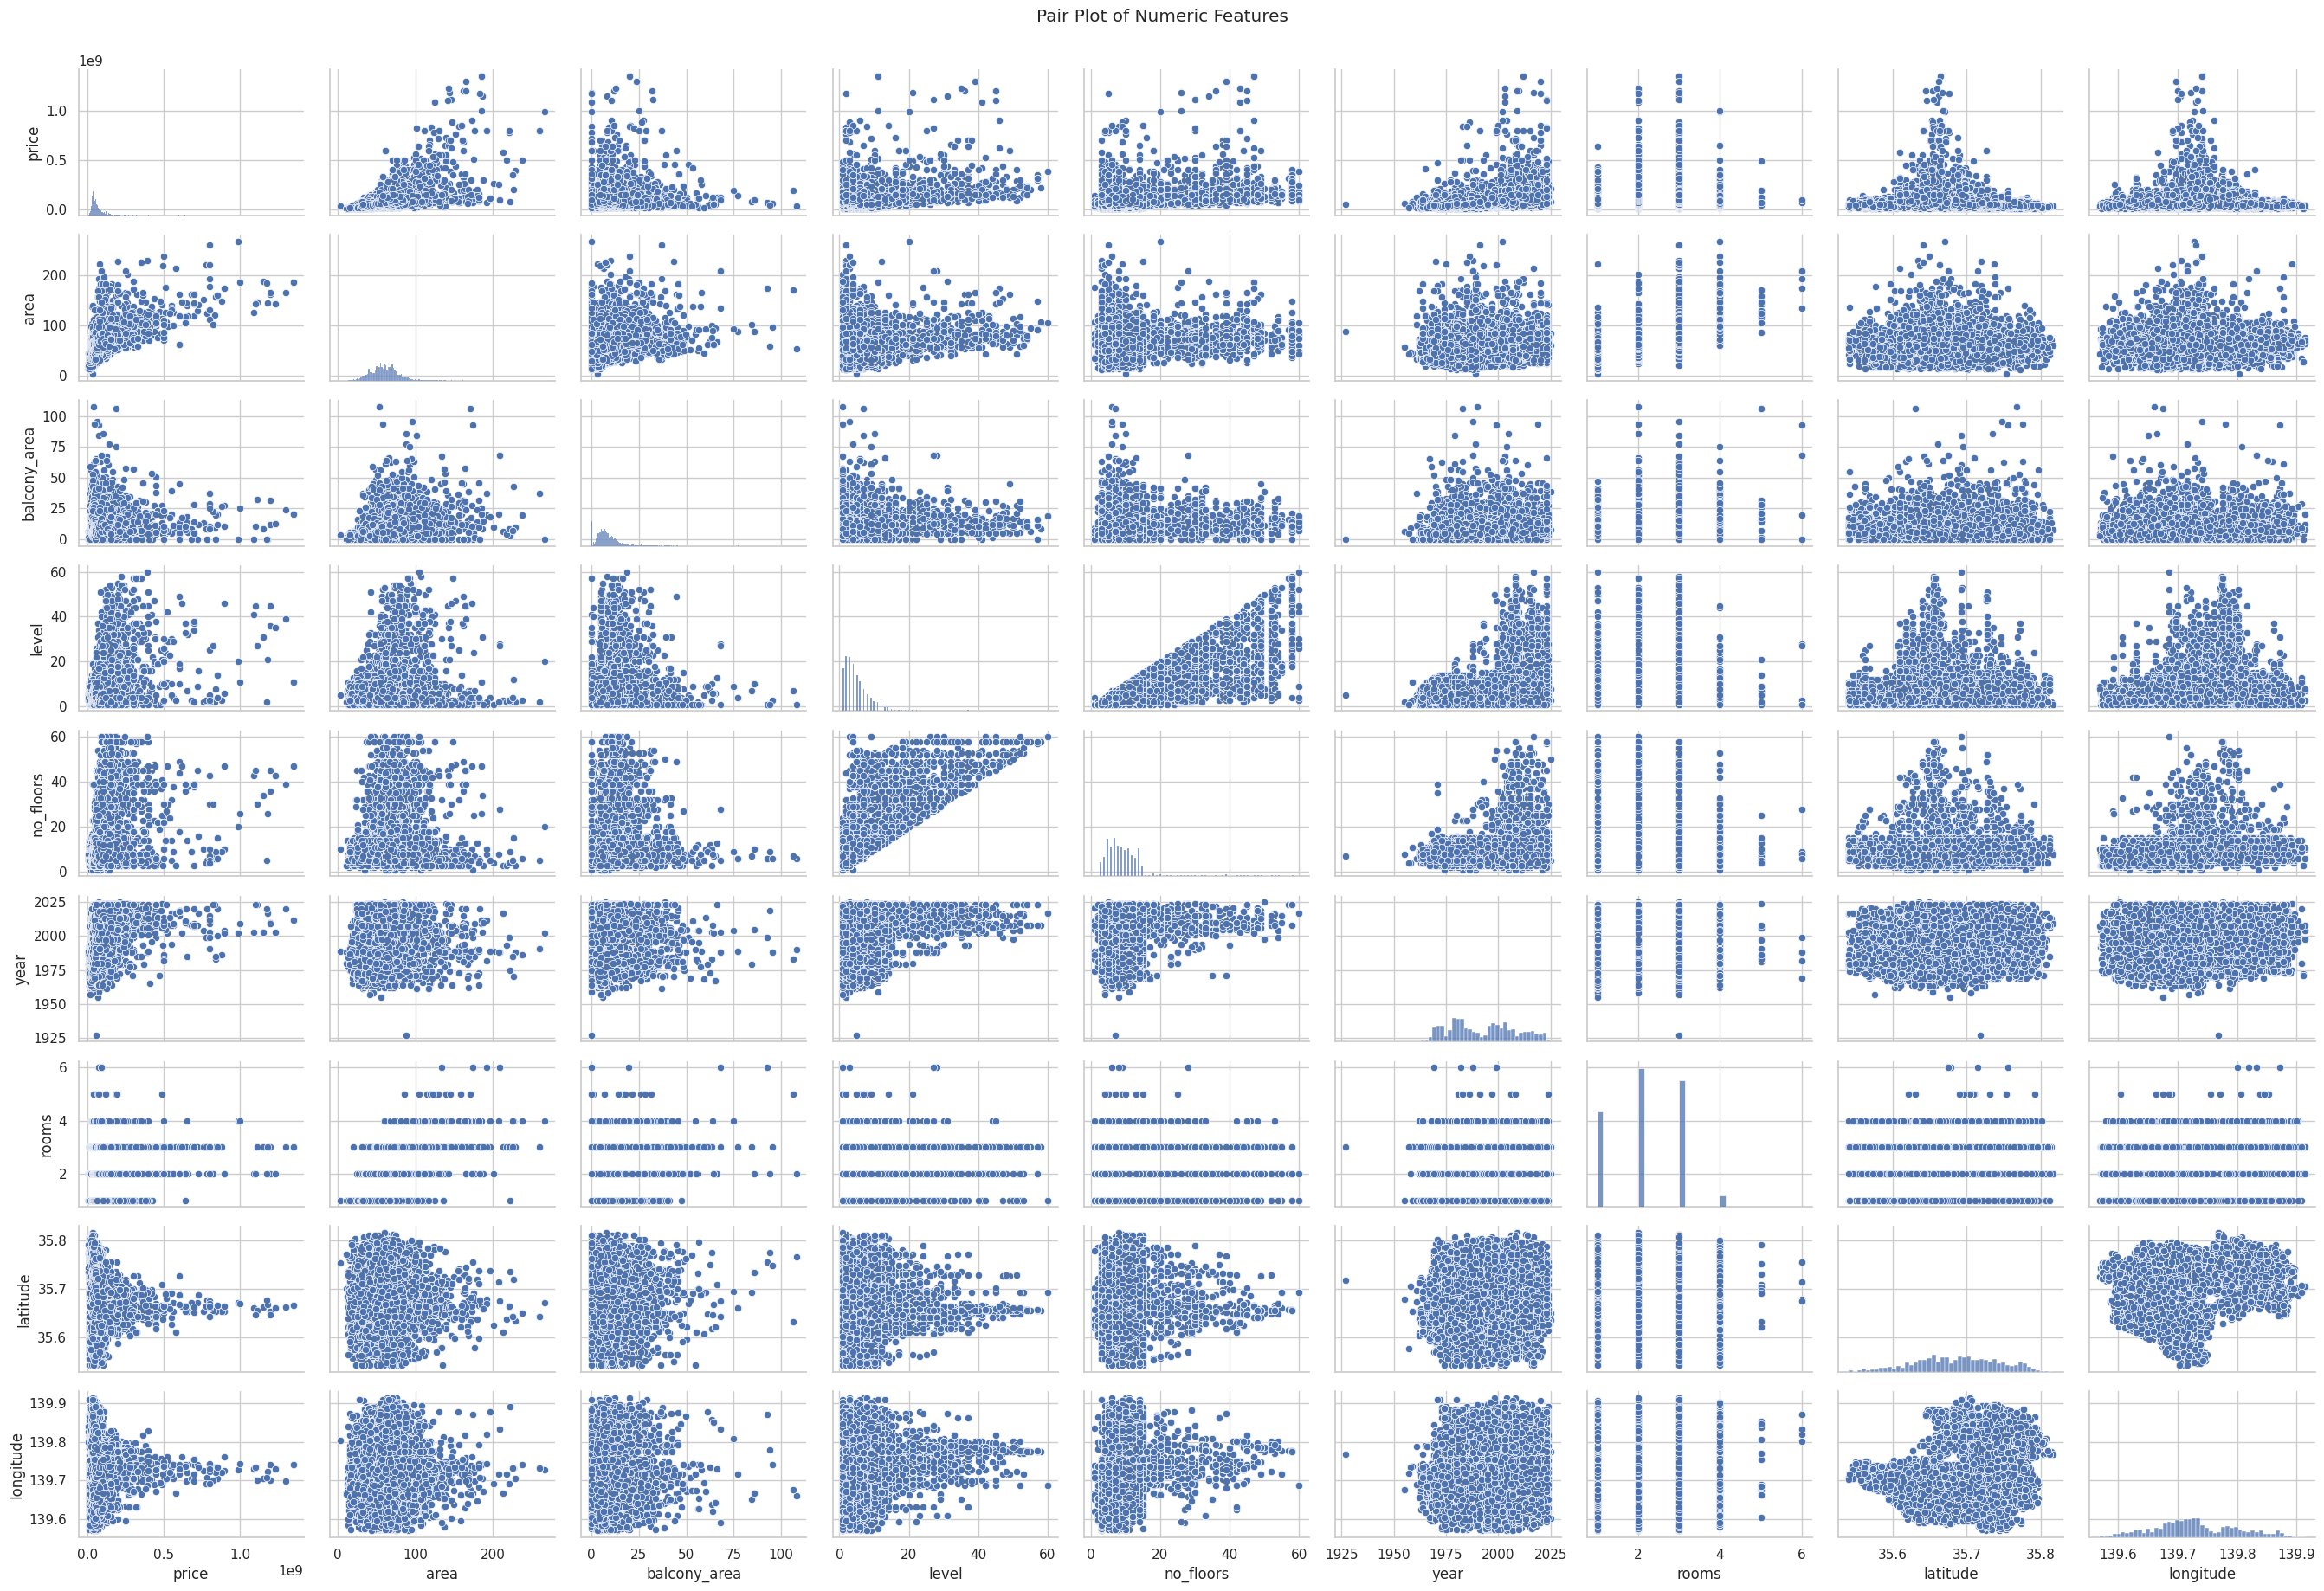

In [171]:
# 2. Pair plot of numeric features
numeric_features = ['price', 'area', 'balcony_area', 'level', 'no_floors', 'year', 'rooms', 'latitude', 'longitude']
sns.pairplot(df[numeric_features], height=2, aspect=1.5)
plt.tight_layout()
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

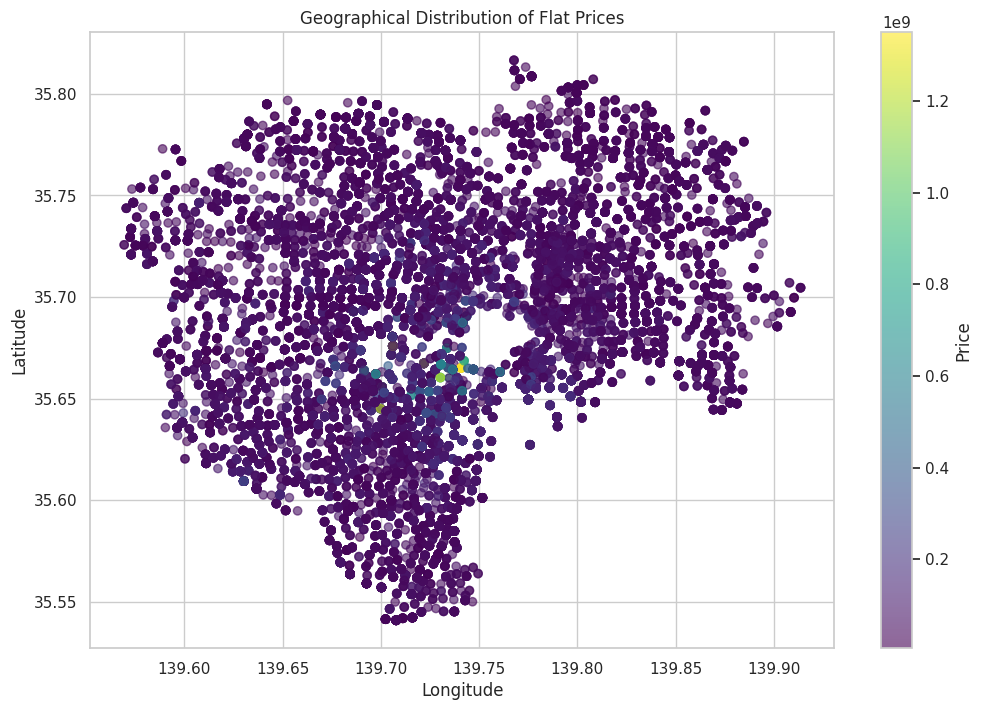

In [172]:
# 3. Geographical visualization of prices
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['price'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Price')
plt.title('Geographical Distribution of Flat Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

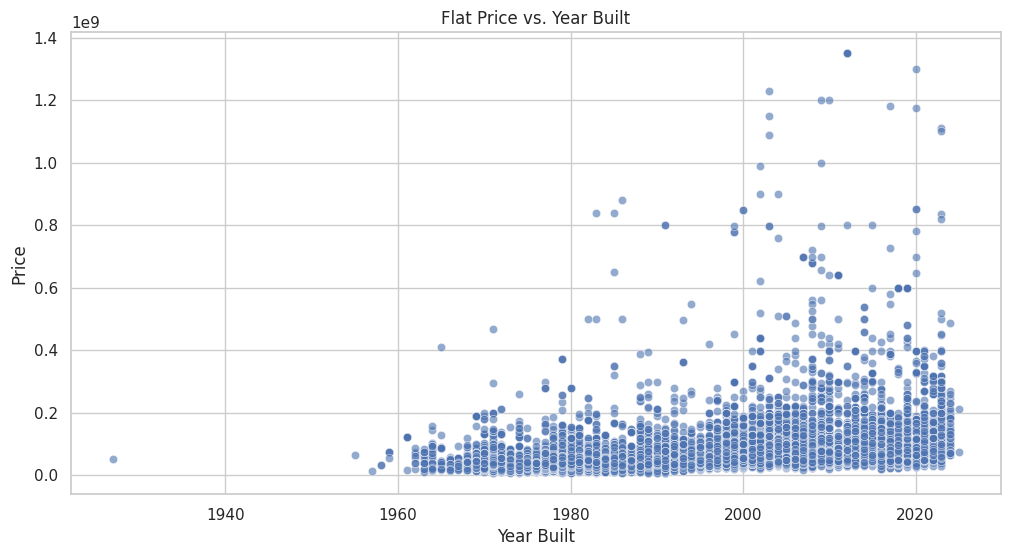

In [173]:
# 4. Year built vs. price analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(x='year', y='price', data=df, alpha=0.6)
plt.title('Flat Price vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When 

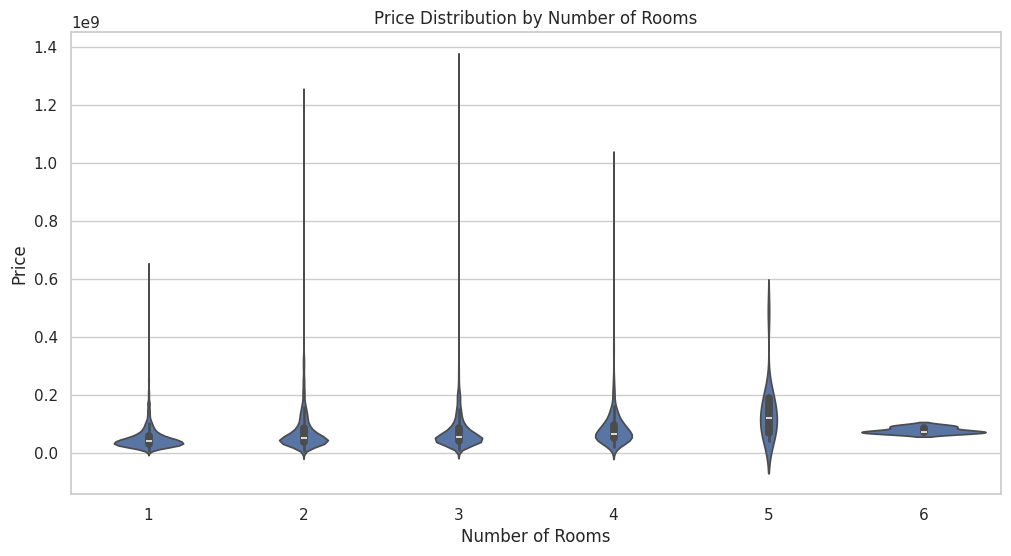

In [174]:
# 5. Room count analysis
plt.figure(figsize=(12, 6))
sns.violinplot(x='rooms', y='price', data=df.astype({'rooms': 'category'}))
plt.title('Price Distribution by Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Price')
plt.show()

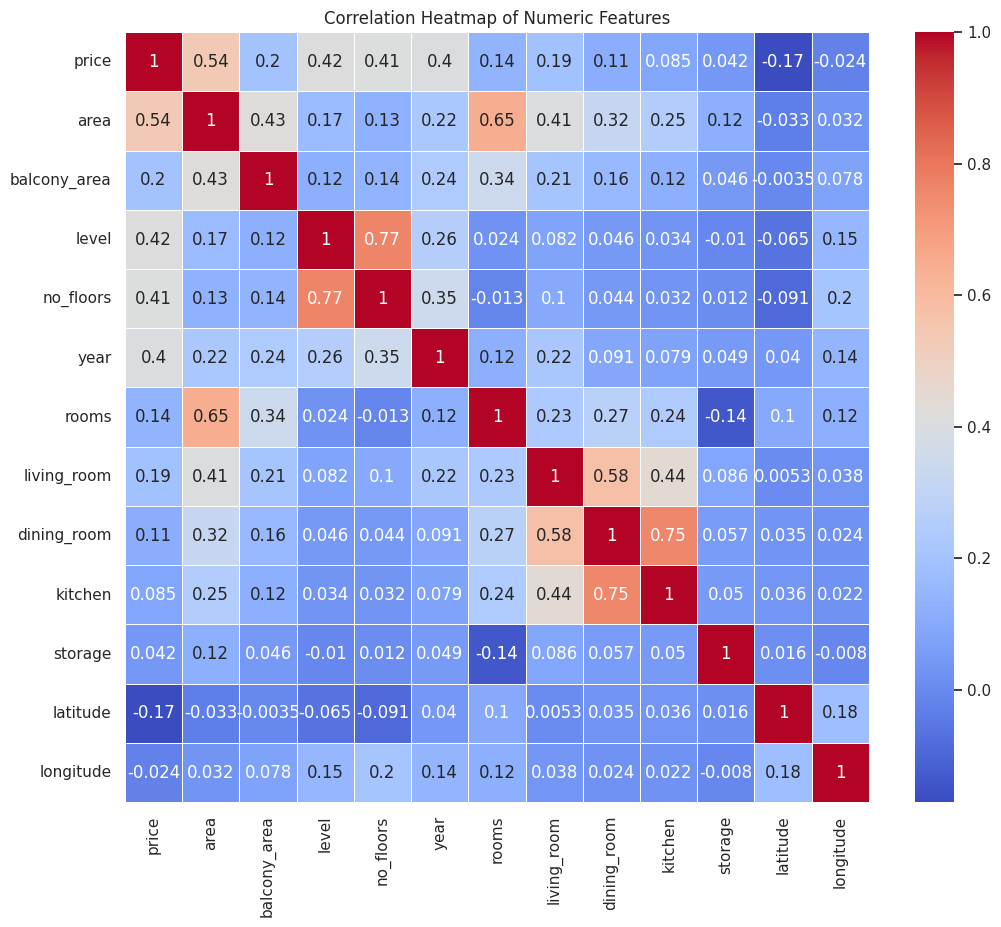

In [175]:
# 4. Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

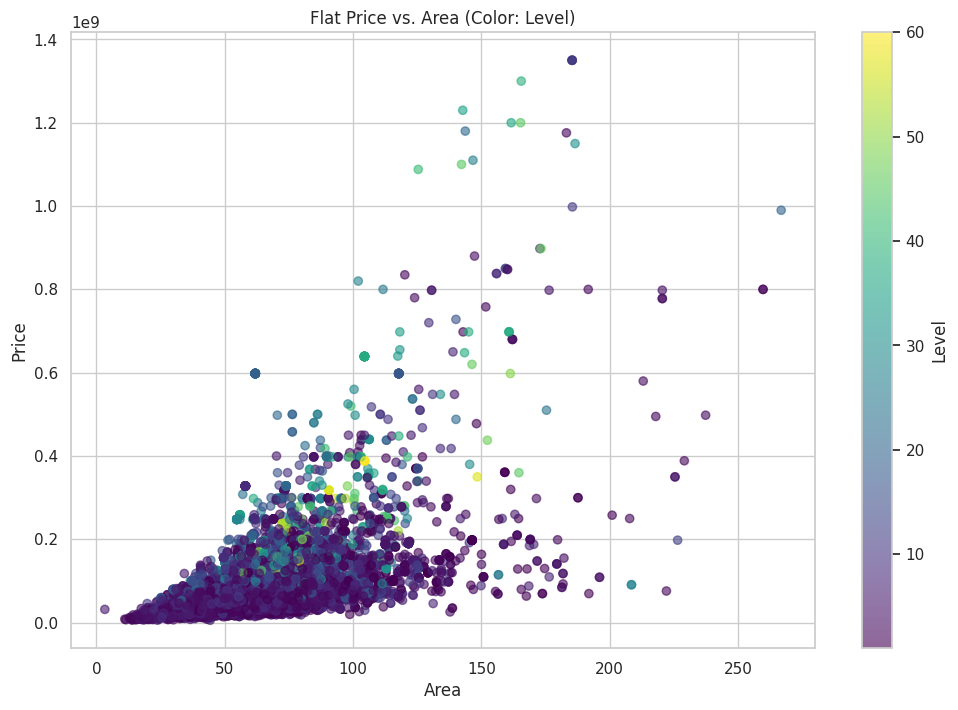

In [176]:
# 6. Area vs. Price with color-coded levels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['area'], df['price'], c=df['level'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Level')
plt.title('Flat Price vs. Area (Color: Level)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

## Normalise X data
- Fit transform using X_train only. Apply to X_train and X_test.

In [177]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale X_train
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale X_test using the fitted transformer from X_train
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Print the scaled DataFrames
X_train_scaled.head()

,area,balcony_area,level,no_floors,year,rooms,living_room,dining_room,kitchen,storage,latitude,longitude
0,0.1,0.0,0.0,0.1,0.6,0.0,0.0,1.0,1.0,0.0,0.6,0.6
1,0.2,0.1,0.4,0.5,0.7,0.0,1.0,1.0,1.0,0.0,0.5,0.6
2,0.2,0.0,0.0,0.1,0.8,0.4,1.0,1.0,1.0,0.0,0.7,0.2
3,0.1,0.0,0.1,0.1,1.0,0.0,1.0,1.0,1.0,0.0,0.6,0.5
4,0.2,0.1,0.0,0.1,0.4,0.2,1.0,1.0,1.0,0.0,0.6,0.3


## Model selection using original dataset
- Try a bunch of different models using 5-fold cross validation. 
- RandomForestRegressor and XGBRegressor had the lowest mean absolute error (MAE).

In [178]:
sklearn_models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), XGBRegressor(), AdaBoostRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), SVR()]

for model in sklearn_models:

    # Cross-validation. Using MAE as the dataset contains significant outliers which MSE and R-squared are sensitive to.
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')

    mae_scores = -scores

    # Print the mean and standard deviation of the accuracy scores
    print(f"{model.__class__.__name__:<30} {mae_scores.mean():>10,.0f} +/- {mae_scores.std():>10,.0f}")

LinearRegression               27,549,455 +/-    904,873
Ridge                          27,329,566 +/-    906,603
Lasso                          27,549,446 +/-    904,873
ElasticNet                     39,152,393 +/-  1,520,290
XGBRegressor                    7,841,240 +/-    417,274
AdaBoostRegressor              71,377,858 +/-  3,959,599
RandomForestRegressor           7,004,275 +/-    706,381
GradientBoostingRegressor      14,263,938 +/-    890,196
SVR                            36,259,661 +/-  2,216,838


## XGBRegressor hyperparameter tuning
- Hyperparameter tuning using grid search and cross validation.
- I actually tested 3-4 options for ('n_estimators'  'max_depth', 'min_child_weight': 1, 'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda') but only changing n_estimators and max_depth improved the performance. The default for the latter two are 'n_estimators': 100 and 'max_depth': 3 but the best found where 500 (can get better if you go higher but benefit above 500 is minimal) and 12 (not better to go higher).


In [179]:
# Define the parameter grid
param_grid = {
    'n_estimators': [900,1200,1500],
    'max_depth': [3, 6, 9],
}

# Create an XGBRegressor instance
xgb_regressor = XGBRegressor()

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Print the best parameters and best score
print(f"Best: {best_score:,.0f} Parameters: {best_params}\n")

results = grid_search.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print(f"MAE: {-mean_score:>10,.0f} +/- {std_score:>6,.0f} Parameters: {params} ")

Best: 6,164,592 Parameters: {'max_depth': 9, 'n_estimators': 1500}

MAE:  8,539,619 +/- 415,376 Parameters: {'max_depth': 3, 'n_estimators': 900} 
MAE:  8,178,751 +/- 412,813 Parameters: {'max_depth': 3, 'n_estimators': 1200} 
MAE:  7,909,270 +/- 380,151 Parameters: {'max_depth': 3, 'n_estimators': 1500} 
MAE:  6,240,193 +/- 451,141 Parameters: {'max_depth': 6, 'n_estimators': 900} 
MAE:  6,189,756 +/- 449,660 Parameters: {'max_depth': 6, 'n_estimators': 1200} 
MAE:  6,166,369 +/- 447,333 Parameters: {'max_depth': 6, 'n_estimators': 1500} 
MAE:  6,164,668 +/- 433,907 Parameters: {'max_depth': 9, 'n_estimators': 900} 
MAE:  6,164,595 +/- 433,911 Parameters: {'max_depth': 9, 'n_estimators': 1200} 
MAE:  6,164,592 +/- 433,912 Parameters: {'max_depth': 9, 'n_estimators': 1500} 


## Feature Importances

In [180]:
# Define the parameter grid
best_params = {
    'n_estimators': 1500,
    'max_depth': 9,
    # 'min_child_weight': 1,
    # 'subsample': 1.0,
    # 'colsample_bytree': 1.0,
    # 'gamma': 0,
    # 'reg_alpha': 0,
    # 'reg_lambda': 0.1
}

# 1. Fit the XGBRegressor model to your training data
xgb_regressor = XGBRegressor(**best_params)
xgb_regressor.fit(X_train, y_train)

# 2. Get the feature importances
feature_importances = xgb_regressor.feature_importances_

# 3. Sort the features by their importance in descending order
features = X_train.columns
importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)
for f, i in importances.items():
    print(f"{f}: {i}")

year: 0.25274658203125
no_floors: 0.24040985107421875
area: 0.15972231328487396
longitude: 0.1400480717420578
latitude: 0.1166892945766449
level: 0.03263738751411438
rooms: 0.026043402031064034
balcony_area: 0.013844333589076996
storage: 0.013358991593122482
living_room: 0.00336461397819221
dining_room: 0.0006503277109004557
kitchen: 0.00048483320279046893


## Remove outliers
- Remove samples that fall outside the price upper and lower bounds

In [105]:
def remove_outliers(df):
    # Calculate Q1 and Q3
    Q1 = df["price"].quantile(0.25)
    Q3 = df["price"].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df_no_outliers = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]

    # Create a DataFrame with only the outliers
    df_outliers = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]

    return df_no_outliers, df_outliers

df, df_outliers = remove_outliers(df_original)

X = df.drop(["price"], axis=1)
y = df["price"]

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBRegressor instance with default parameters
xgb_regressor = XGBRegressor(**best_params)

# Perform cross-validation with 5 folds and scoring using neg_mean_absolute_error
scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():,.2f} +/- {mae_scores.std():,.2f}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
           ^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
                                        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.12/site-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Category: object, URL: object, plan: object, address: object, features: object, address_block: object, converted_address: object


## Recursive feature selection
- Systematically remove the least important features
- Keep the best 10
- Reduces MAE from around 6000 to 5200.

In [34]:
# Create an XGBRegressor instance with the best parameters
xgb_regressor = XGBRegressor(**best_params)

# Create an RFE instance, specifying the estimator and the number of features to select
# Adjust the number of features as needed
rfe = RFE(estimator=xgb_regressor, n_features_to_select=10)

# Fit the RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['building_type_apartment', 'building_type_mansion', 'year', 'no_floors',
       'layout_1LDK', 'layout_2LDK', 'layout_4DK', 'area', 'latitude',
       'longitude'],
      dtype='object')


In [35]:

xgb_regressor = XGBRegressor(**best_params)

# Select the features from X_train_scaled_filtered
X_train_selected = X_train[selected_features]

# Perform cross-validation with 5 folds and scoring using neg_mean_absolute_error
scores = cross_val_score(xgb_regressor, X_train_selected, y_train, cv=5, scoring="neg_mean_absolute_error")

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():,.2f} +/- {mae_scores.std():,.2f}")

Mean/std: 5210.30 +/- 67.97


## Train the final model
- Using X_train after removing outliers and only using the top 10 features found using RFE
- Tested the final model using the X_test data that was not previously used.
- MAE similar to the cross validation on the training data (5000).

Mean MAE: 4555.23


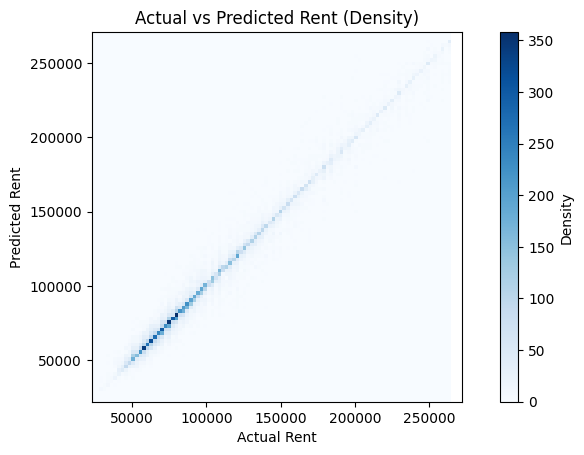

In [8]:
selected_features = ['building_type_apartment', 'building_type_mansion', 'year', 'no_floors',
       'layout_1LDK', 'layout_2LDK', 'layout_4DK', 'area', 'latitude',
       'longitude']

X_test_selected = X_test[selected_features]
X_train_selected = X_train[selected_features]

best_params = {
    'n_estimators': 500,
    'max_depth': 12,
}

# Create an instance of the RandomForestRegressor model
model = XGBRegressor(**best_params)

# Train the model using X_train_selected and y_train
model.fit(X_train_selected, y_train)

# Test the model on X_test_selected
predictions = model.predict(X_test_selected)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_rent_test, predictions)

print(f"Mean MAE: {mae:,.2f}")

# Plot the predicted values vs the actual y values with density
plt.hist2d(y_rent_test, predictions, bins=100, cmap='Blues')
plt.colorbar(label='Density')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs Predicted Rent (Density)')
plt.axis('square')  # Set the axes to be square
# plt.xlim(0, 2500000)  # Set the x-axis limits
# plt.ylim(0, 2500000)  # Set the y-axis limits
plt.show()